### Considered model: four-bar linkage (= two link manipulator + one link manipulator + rigid coupling)

<img src="images/fourbar.png">


In [1]:
%load_ext ipydex.displaytools
%matplotlib inline

import os
import sympy as sp
import numpy as npy  # we need `np` later 
from sympy import sin, cos, pi
from sympy.interactive import printing
import symbtools as st
import symbtools.modeltools as mt
import symbtools.visualisation as vt
from symbtools.modeltools import Rz # Rotationsmatrix in the xy plane (c, -s; s, c)
import scipy.integrate as sc_integrate
import matplotlib.pyplot as pl
from assimulo.solvers import IDA # Imports the solver IDA from Assimulo
from assimulo.problem import Implicit_Problem # Imports the problem formulation from Assimulo
import ipydex
plt = pl

printing.init_printing(1)

Could not find GLIMDA.


In [2]:
t = sp.Symbol('t')  # time variable

# coordinates
np = 2
nq = 1
n = np + nq
pp = st.symb_vector("p1:{}".format(np+1)) ##:T
qq = st.symb_vector("q1:{}".format(nq+1)) ##:T


aa = st.symb_vector("a1:{}".format(nq+1)) ##:T

ttheta = st.row_stack(pp, qq) ##:T
tthetad = st.time_deriv(ttheta, ttheta) ##:T
tthetadd = st.time_deriv(ttheta, ttheta, order=2) ##:T
st.make_global(ttheta, tthetad, tthetadd)

---


---


---


---


---


---


In [3]:
params = sp.symbols('s1, s2, s3, m1, m2, m3, J1, J2, J3, l1, l2, l3, l4, kappa1, kappa2, g')
parameter_values = list(dict(s1=1/2, s2=1/2, s3=1/2, m1=1, m2=1, m3=3, J1=1/12 , J2=1/12, J3=1/12,
                             l1=0.8, l2=1.5, l3=1.5, l4=2, kappa1=3/2 , kappa2=14.715, g=9.81).items())
st.make_global(params)

# ttau = sp.symbols('tau')
tau1, tau2 = ttau = st.symb_vector("tau1, tau2")


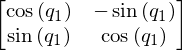

In [4]:
Rz(q1) # Rotationsmatirx

Specify the geometry (joints G and centers of masses S)

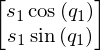

---


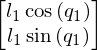

---


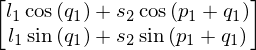

---


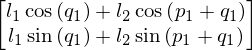

---


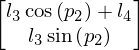

---


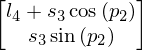

---


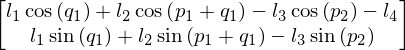

---


In [5]:
# uni vectors

ex = sp.Matrix([1, 0]) 
ey = sp.Matrix([0, 1]) 

# Basis 1 und 2
B1 = sp.Matrix([0, 0])
B2 = sp.Matrix([l4, 0])

# Coordinates two link manipulator
S1 = Rz(q1)*ex*s1 ##:

G1 = Rz(q1)*ex*l1 ##:

S2 = G1 + Rz(q1 + p1)*ex*s2 ##:

G2 = G1 + Rz(q1 + p1)*ex*l2 ##:


# one link manipulator
G2b = B2 + Rz(p2)*ex*l3 ##:

S3 = B2 + Rz(p2)*ex*s3 ##:

constraints = sp.Matrix([G2 - G2b]) ##:


# Time derivative
Sd1, Sd2, Sd3 = st.col_split(st.time_deriv(st.col_stack(S1, S2, S3), ttheta))

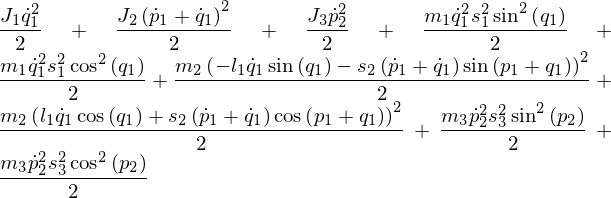

---


---


In [6]:
# kinetic energy

T_rot = (J1*qdot1**2 + J2*(qdot1 + pdot1)**2 + J3*(pdot2)**2)/2
T_trans = ( m1*Sd1.T*Sd1  +  m2*Sd2.T*Sd2 +  m3*Sd3.T*Sd3 )/2

T = T_rot + T_trans[0] ##:

# potential energy
V = m1*g*S1[1] + m2*g*S2[1] + m3*g*S3[1] ##:

In [7]:
import importlib as il

il.reload(vt)

<module 'symbtools.visualisation' from '/media/workcard/workstickdir/projekte/rst_python/symbtools-TUD-RST-Account/symbtools/visualisation.py'>

In [8]:
vis = vt.Visualiser(ttheta, xlim=(-2, 4), ylim=(-3, 3))
vis.add_linkage(st.col_stack(B1, G1, G2,).subs(parameter_values))
vis.add_linkage(st.col_stack(G2b, B2).subs(parameter_values))
vis.interact(p1=(1.0, 3.14, 0.05,), q1=(0, 1*npy.pi, .1), free_vars=q1, constraints=constraints.subs(parameter_values))

interactive(children=(FloatSlider(value=2.05, description='p1', max=3.14, min=1.0, step=0.05), FloatSlider(val…

In [9]:
vt.interact?

In [10]:
external_forces = [0 , 0, tau1]

%time mod = mt.generate_symbolic_model(T, V, ttheta, external_forces, constraints=constraints)


CPU times: user 9.66 s, sys: 16 ms, total: 9.68 s
Wall time: 9.68 s


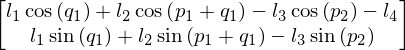

In [11]:
# condition that endeffectors of the two manipulators are at the same place (x and y)

mod.constraints

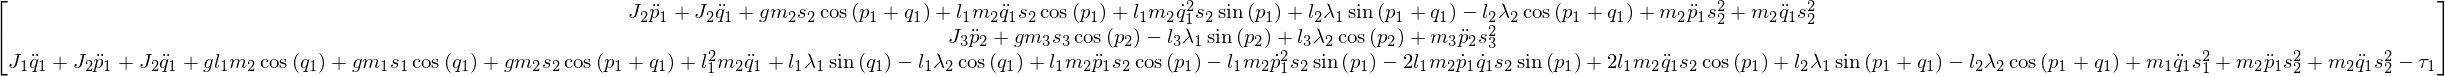

In [12]:
# ODE-part oft the equation

mod.eqns

### Creation of DAE System

In [13]:
# generate a dae object

dae = mod.calc_dae_eq(parameter_values)
dae.generate_eqns_funcs()

In [14]:
# show dae variables

dae.yy ##:T
dae.yyd ##:T

---


---


### Calculate consistent initial values by optimization (with given hints)

In [15]:
yy0, yyd0 = dae.calc_consistent_init_vals(p1=0.3) ##:

t0 = 0


# check if all values are almost zero (-> initial values fulfill the model)
assert npy.allclose(dae.model_func(t0, yy0, yyd0), 0)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 91
         Function evaluations: 176
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 33
         Function evaluations: 67


(yy0, yyd0) := (array([ 0.3       ,  1.74961317,  0.50948621,  0.        ,  0.        ,  0.        , -0.27535424,  0.5455313 ]),
 array([  0.        ,   0.        ,   0.        ,  23.53968609,   2.82766884, -14.48960943,  -0.        ,   0.        ]))

---


In [16]:
model = Implicit_Problem(dae.model_func, yy0, yyd0, t0)
model.name = 'fourbar linkage'

# indicate which components of y are differential (1) and which are purely algebraic (0)
# model.algvar = dae.diff_alg_vars ##:

sim = IDA(model)
# sim.suppress_alg = True #Necessary to set to True for >1 index problem

# values <= 30 produce lots of output
sim.verbosity = 0

In [17]:
tfinal = 10.0        # Specify the final time
ncp = 500            # Number of communication points (number of return points)

# takes about 48 seconds
tt_sol, yy_sol, yyd_sol = sim.simulate(tfinal, ncp) 

No initialization defined for the problem.
No finalization defined for the problem.
Final Run Statistics: fourbar linkage 

 Number of steps                                 : 3536
 Number of function evaluations                  : 5693
 Number of Jacobian evaluations                  : 196
 Number of function eval. due to Jacobian eval.  : 1568
 Number of error test failures                   : 92
 Number of nonlinear iterations                  : 5693
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                       : IDA (BDF)
 Maximal order                : 5
 Suppressed algebr. variables : False
 Tolerances (absolute)        : 1e-06
 Tolerances (relative)        : 1e-06

Simulation interval    : 0.0 - 10.0 seconds.
Elapsed simulation time: 19.395227671950124 seconds.


In [18]:
ttheta_sol = yy_sol[:, :mod.dae.ntt]
ttheta_d_sol = yy_sol[:, mod.dae.ntt:mod.dae.ntt*2]

Text(0.5, 1.0, 'angular velocities')

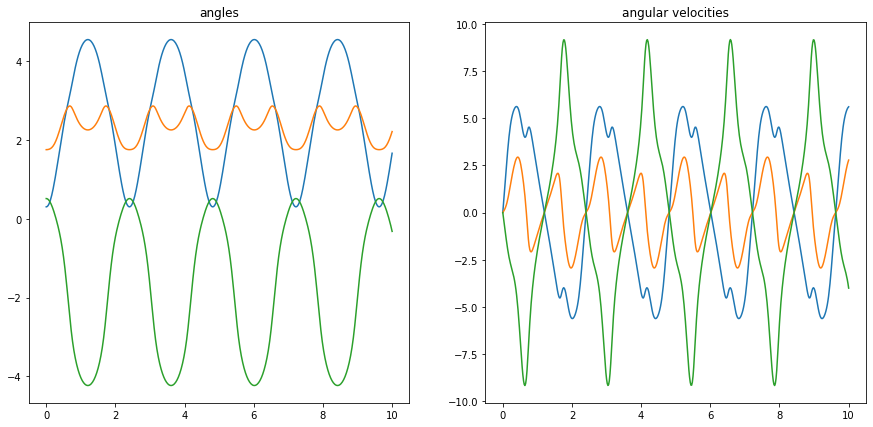

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7)); plt.sca(ax1)

ax1.plot(tt_sol, ttheta_sol)
ax1.set_title("angles")

ax2.plot(tt_sol, ttheta_d_sol)
ax2.set_title("angular velocities")

####  Visualization and Animation

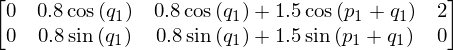

---


In [20]:
joint_pos_expr = st.col_stack(B1, G1, G2, B2).subs(parameter_values) ##:
joint_pos_func = st.expr_to_func(mod.tt, joint_pos_expr, keep_shape=True)

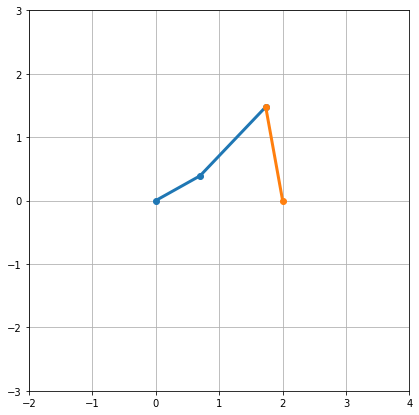

In [31]:
# Create object for Animation

simanim = vt.SimAnimation(mod.xx[:3], tt_sol, yy_sol[:, :3], figsize=(14, 7))
simanim.add_visualiser(vis)

# plot first frame
simanim.plot_frame(0)

In [26]:
# this might need to be adapted on other systems

plt.rcParams["animation.codec"] = "libvpx-vp9"  # codec for webm
plt.rcParams['animation.ffmpeg_path'] = os.path.join(os.getenv("CONDA_PREFIX"), "bin", "ffmpeg")
# plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
writer = animation.FFMpegWriter(fps=30)

fname="fourbar_linkage_free_movement2.webm"
simanim.save(fname, dpi=30)

In [30]:
vt.display_video_file(fname)